In [1]:
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

logger = Logger()

image_representation_reduced_to_n_pcs = 50

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:20:02 | INFO     | ℹ️ This notebook is running for mouse m02_d3


In [3]:
vgg19_fev_results = futils.read_json_file_as_dataframe('./prediction.json')
vgg19_fev_pcs = vgg19_fev_results[vgg19_fev_results['n_pcs'] == image_representation_reduced_to_n_pcs].reset_index(drop=True)
vgg19_fev_pcs

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,50.0,0.016424,0.110453
1,conv3_4,50.0,0.014801,0.104822
2,conv4_4,50.0,0.014402,0.130997
3,conv5_4,50.0,0.008928,0.100801
4,fc2,50.0,0.008059,0.098554


In [4]:
vgg19_dim_results = futils.read_json_file_as_dataframe('./dimensionality.json')
vgg19_dim_results

,layer,alpha,alpha_no_pc1
0,conv2_2,1.394331,1.418310
1,conv3_4,1.524415,1.541573
2,conv4_4,1.626546,1.663550
3,conv5_4,1.677220,1.709405
4,fc2,1.592539,1.602094


In [5]:
vgg19_rsa_results = futils.read_json_file_as_dataframe('./representational_similarity.json')
vgg19_rsa_pcs = vgg19_rsa_results[vgg19_rsa_results['n_pcs'] == image_representation_reduced_to_n_pcs].reset_index(drop=True)
vgg19_rsa_pcs

,layer,n_pcs,spearman_correlation
0,conv2_2,50.0,0.112718
1,conv3_4,50.0,0.120117
2,conv4_4,50.0,0.096655
3,conv5_4,50.0,0.074598
4,fc2,50.0,0.061439


In [6]:
vgg19_sem_results = futils.read_json_file_as_dataframe('./semanticity.json')
vgg19_sem_pcs = vgg19_sem_results[vgg19_sem_results['n_pcs'] == image_representation_reduced_to_n_pcs].reset_index(drop=True)
vgg19_sem_pcs

,layer,n_pcs,silhouette_score
0,conv2_2,50,-0.087484
1,conv3_4,50,-0.061713
2,conv4_4,50,0.006110
3,conv5_4,50,0.264032
4,fc2,50,0.461334


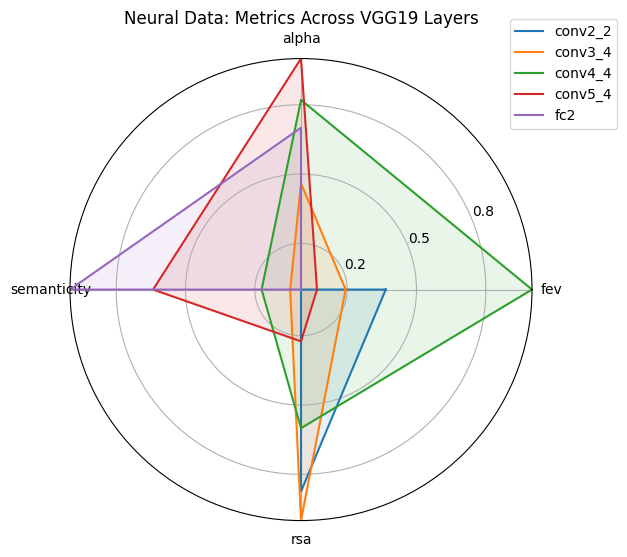

In [7]:
data = {
    'layer': vgg19_fev_pcs['layer'].values,
    'fev': vgg19_fev_pcs['mean_fev'].values,
    'alpha': vgg19_dim_results['alpha'].values,
    'semanticity': vgg19_sem_pcs['silhouette_score'].values,
    'rsa': vgg19_rsa_pcs['spearman_correlation'].values
}
df = pd.DataFrame(data)

# Normalise each metric to [0, 1]
metrics = ['fev', 'alpha', 'semanticity', 'rsa']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[metrics] = scaler.fit_transform(df[metrics])

labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, row in df_scaled.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=row['layer'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_yticklabels(['0.2', '0.5', '0.8'])
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title("Neural Data: Metrics Across VGG19 Layers")
plt.show()